## Load and Process Dataset



In [6]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import csv
from nltk import word_tokenize
import nltk
nltk.download('punkt')

import string

summaries = []
texts = []

def clean(text):
    text = text.lower()
    printable = set(string.printable)
    text = "".join(list(filter(lambda x: x in printable, text))) #filter funny characters, if any.
    return text

text_max_len = 500
text_min_len = 25
summary_max_len = 30
vocab2idx = {}

#Data from https://www.kaggle.com/snap/amazon-fine-food-reviews
with open('/content/drive/MyDrive/Colab Notebooks/Reviews.csv') as csvfile:

    Reviews = csv.DictReader(csvfile)

    i=0

    for row in Reviews:

        text = row['Text']
        summary = row['Summary']

        if len(text) <= text_max_len and len(text) >= text_min_len and len(summary) <= summary_max_len:
            #print(i)

            clean_text = clean(text)
            clean_summary = clean(summary)

            tokenized_summary = word_tokenize(clean_summary)
            tokenized_text = word_tokenize(clean_text)

            # BUILD VOCABULARY

            for word in tokenized_text:
                if word not in vocab2idx:
                    vocab2idx[word]=len(vocab2idx)

            for word in tokenized_summary:
                if word not in vocab2idx:
                    vocab2idx[word]=len(vocab2idx)

            ## ________________

            summaries.append(tokenized_summary)
            texts.append(tokenized_text)

            if i%10000==0:
                print("Processing data # {}".format(i))

            i+=1

print("\n# of Data: {}".format(len(texts)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processing data # 0
Processing data # 10000
Processing data # 20000
Processing data # 30000
Processing data # 40000
Processing data # 50000
Processing data # 60000
Processing data # 70000
Processing data # 80000
Processing data # 90000
Processing data # 100000
Processing data # 110000
Processing data # 120000
Processing data # 130000
Processing data # 140000
Processing data # 150000
Processing data # 160000
Processing data # 170000
Processing data # 180000
Processing data # 190000
Processing data # 200000
Processing data # 210000
Processing data # 220000
Processing data # 230000
Processing data # 240000
Processing data # 250000
Processing data # 260000
Processing data # 270000
Processing data # 280000
Processing data # 290000
Processing data # 300000
Processing data # 310000
Processing data # 320000
Processing data # 330000

# of Data: 337465


## Random Sample

In [8]:
import random

index = random.randint(0,len(texts)-1)

print("SAMPLE CLEANED & TOKENIZED TEXT: \n\n{}\n\n".format(texts[index]))
print("SAMPLE CLEANED & TOKENIZED SUMMARY: \n\n{}\n".format(summaries[index]))

SAMPLE CLEANED & TOKENIZED TEXT: 

['great', 'deal', ',', 'i', 'have', 'checked', 'around', 'and', 'you', 'have', 'the', 'best', 'deal', ',', 'that', 'i', 'have', 'found', ',', 'on', 'the', '``', 'kay', "'s", 'naturals', 'protein', 'chips', "''", '.', '<', 'br', '/', '>', 'these', 'are', 'a', 'good', 'source', 'of', 'protein', ',', 'crunch', 'and', 'great', 'price.', '<', 'br', '/', '>', 'thanks', 'muchly']


SAMPLE CLEANED & TOKENIZED SUMMARY: 

['fantastic']



## Load Embeddings


In [9]:
import numpy as np

vocab = []
embd = []
special_tags = ['<UNK>','<PAD>','<EOS>']


def loadEmbeddings(filename):
    vocab2embd = {}

    with open(filename) as infile:
        for line in infile:
            row = line.strip().split(' ')
            word = row[0].lower()
            if word not in vocab2embd:
                vocab2embd[word]=np.asarray(row[1:],np.float32)

    print('Embedding Loaded.')
    return vocab2embd

vocab2embd = loadEmbeddings('/content/drive/MyDrive/Colab Notebooks/glove.twitter.27B.100d.txt')

for word in vocab2idx:
    if word in vocab2embd:
        vocab.append(word)
        embd.append(vocab2embd[word])

for special_tag in special_tags:
    vocab.append(special_tag)
    embd.append(np.random.rand(len(embd[0]),))

vocab2idx = {word:idx for idx,word in enumerate(vocab)}
embd = np.asarray(embd,np.float32)

print("Vocabulary Size: {}".format(len(vocab2idx)))




Embedding Loaded.
Vocabulary Size: 42709


In [10]:
print(vocab2idx['<EOS>'])

42708


## Vectorize Data

In [11]:
vec_texts=[]
vec_summaries=[]

for text,summary in zip(texts,summaries):
    # Replace out of vocab words with index for '<UNK>' tag
    vec_texts.append([vocab2idx.get(word,vocab2idx['<UNK>']) for word in text])
    vec_summaries.append([vocab2idx.get(word,vocab2idx['<UNK>']) for word in summary])

## Shuffle Data

In [12]:
import random
random.seed(101)

texts_idx = [idx for idx in range(len(vec_texts))]
random.shuffle(texts_idx)

vec_texts = [vec_texts[idx] for idx in texts_idx]
vec_summaries = [vec_summaries[idx] for idx in texts_idx]

## Split Data into train, validation, and test sets.

In [13]:
# Use first 10000 data for testing, the next 10000 data for validation, and rest for training

test_summaries = vec_summaries[0:10000]
test_texts = vec_texts[0:10000]

val_summaries = vec_summaries[10000:20000]
val_texts = vec_texts[10000:20000]

train_summaries = vec_summaries[20000:]
train_texts = vec_texts[20000:]

## Bucket And Batch Function

In [14]:
def bucket_and_batch(texts,summaries,batch_size=32):

    # Sort summaries and texts according to the length of text
    # (So that texts with similar lengths tend to remain in the same batch and thus require less padding)

    text_lens = [len(text) for text in texts]
    sortedidx = np.flip(np.argsort(text_lens),axis=0)
    texts=[texts[idx] for idx in sortedidx]
    summaries=[summaries[idx] for idx in sortedidx]

    batches_text=[]
    batches_summary=[]
    batches_true_text_len = []
    batches_true_summary_len = []

    i=0
    while i < (len(texts)-batch_size):

        max_len = len(texts[i])

        batch_text=[]
        batch_summary=[]
        batch_true_text_len=[]
        batch_true_summary_len=[]

        for j in range(batch_size):

            padded_text = texts[i+j]
            padded_summary = summaries[i+j]

            batch_true_text_len.append(len(texts[i+j]))
            batch_true_summary_len.append(len(summaries[i+j])+1)

            while len(padded_text) < max_len:
                padded_text.append(vocab2idx['<PAD>'])

            padded_summary.append(vocab2idx['<EOS>']) #End of Sentence Marker
            while len(padded_summary) < summary_max_len+1:
                padded_summary.append(vocab2idx['<PAD>'])


            batch_text.append(padded_text)
            batch_summary.append(padded_summary)

        batches_text.append(batch_text)
        batches_summary.append(batch_summary)
        batches_true_text_len.append(batch_true_text_len)
        batches_true_summary_len.append(batch_true_summary_len)

        i+=batch_size

    return batches_text, batches_summary, batches_true_text_len, batches_true_summary_len

## Prepare Batches

In [15]:
train_batches_text, train_batches_summary, train_batches_true_text_len, train_batches_true_summary_len \
= bucket_and_batch(train_texts, train_summaries)

val_batches_text, val_batches_summary, val_batches_true_text_len, val_batches_true_summary_len \
= bucket_and_batch(val_texts, val_summaries)

test_batches_text, test_batches_summary, test_batches_true_text_len, test_batches_true_summary_len \
= bucket_and_batch(test_texts, test_summaries)

## Save Data

In [16]:
import json

d = {}

d["vocab"] = vocab2idx
d["embd"] = embd.tolist()
d["train_batches_text"] = train_batches_text
d["test_batches_text"] = test_batches_text
d["val_batches_text"] = val_batches_text
d["train_batches_summary"] = train_batches_summary
d["test_batches_summary"] = test_batches_summary
d["val_batches_summary"] = val_batches_summary
d["train_batches_true_text_len"] = train_batches_true_text_len
d["val_batches_true_text_len"] = val_batches_true_text_len
d["test_batches_true_text_len"] = test_batches_true_text_len
d["train_batches_true_summary_len"] = train_batches_true_summary_len
d["val_batches_true_summary_len"] = val_batches_true_summary_len
d["test_batches_true_summary_len"] = test_batches_true_summary_len

with open('/content/drive/MyDrive/Colab Notebooks/Amazon_Reviews_Processed.json', 'w') as outfile:
    json.dump(d, outfile)


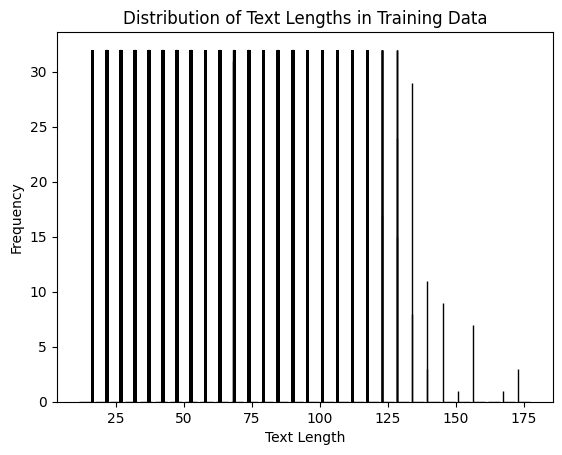

In [17]:
import matplotlib.pyplot as plt

# Load your processed data from the JSON file
with open('/content/drive/MyDrive/Colab Notebooks/Amazon_Reviews_Processed.json', 'r') as infile:
    data = json.load(infile)

train_batches_true_text_len = data["train_batches_true_text_len"]

# Plotting the distribution of text lengths
plt.hist(train_batches_true_text_len, bins=30, edgecolor='black')
plt.title('Distribution of Text Lengths in Training Data')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


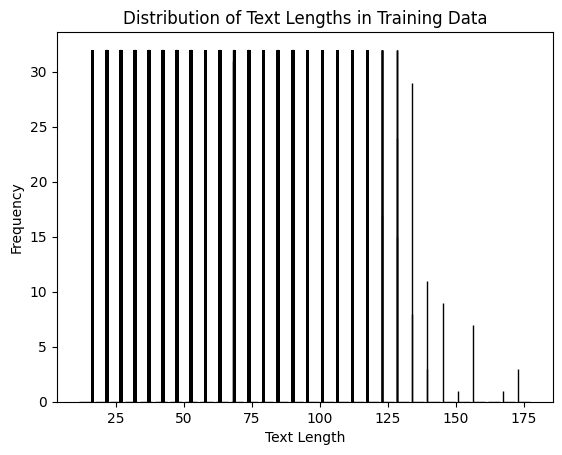

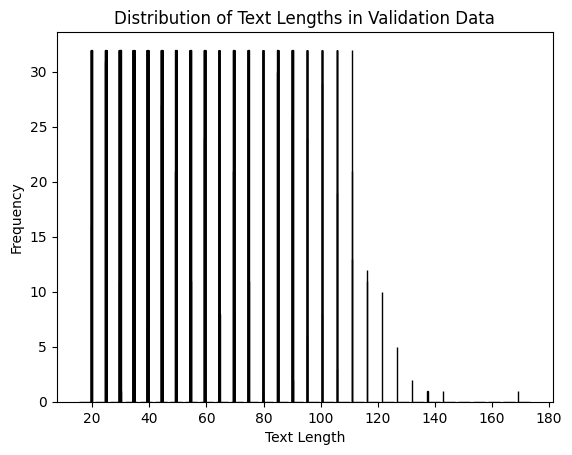

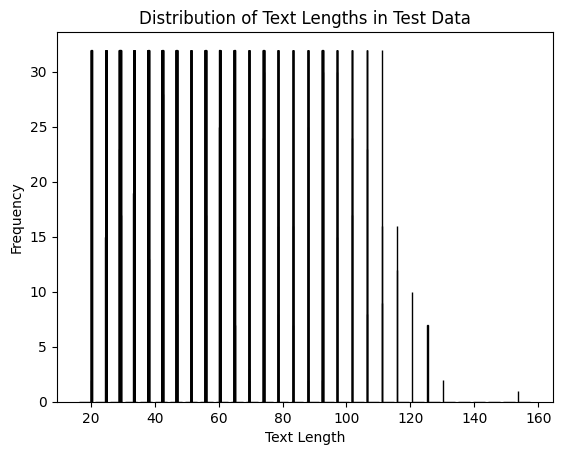

In [19]:
import matplotlib.pyplot as plt

def visualize_lengths(batches_true_text_len, batches_true_summary_len, dataset_name):
    # Plotting the distribution of text lengths
    plt.hist(batches_true_text_len, bins=30, edgecolor='black')
    plt.title(f'Distribution of Text Lengths in {dataset_name} Data')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()


# Visualize training data
visualize_lengths(train_batches_true_text_len, train_batches_true_summary_len, 'Training')

# Visualize validation data
visualize_lengths(val_batches_true_text_len, val_batches_true_summary_len, 'Validation')

# Visualize test data
visualize_lengths(test_batches_true_text_len, test_batches_true_summary_len, 'Test')
